In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('POP.csv')
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


In [2]:
df['population'] = df['value']
df = df[['population', 'date']]
df['date']= pd.to_datetime(df['date'])
df.head()

,population,date
0,156309.0,1952-01-01
1,156527.0,1952-02-01
2,156731.0,1952-03-01
3,156943.0,1952-04-01
4,157140.0,1952-05-01


In [3]:
nan_count = df.isnull().sum().sum()
print('Number of NaN values:', nan_count)

df.isnull(). values. any() 

Number of NaN values: 0


False

In [4]:
df.nunique()


population    816
date          816
dtype: int64

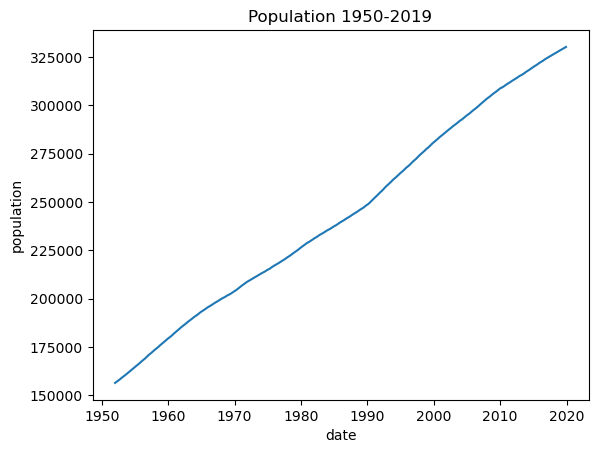

In [5]:
plt.plot(df.date,df.population)
plt.title('Population 1950-2019')
plt.xlabel('date')
plt.ylabel('population')
plt.show()


The chart above show us that this dataset have a very linear pattern, so our solution should have some very good results

In [6]:
# Function to convert the dataset to a timeseries (specific for datasets with only the target column used)
def create_window(target, window=1, offset=0):
    feature_new, target_new = [], []
    # Convert our series to a numpy array
    target_np = target.to_numpy()
    for index in range(window, target.shape[0] - offset):
        feature_new.append(target_np[index - window: index])
        target_new.append(target_np[index+offset])
    return np.array(feature_new), np.array(target_new)

The create_window function is used to create the timeseries based on the target column we want. It assumes the data is already sorted by date and values are not null

In [7]:
df = df.sort_values(by=['date'])
window = 5
feature, target = create_window(df['population'], window=window)
print(feature[0])
print(target[0])
print(df.head(6))

[156309. 156527. 156731. 156943. 157140.]
157343.0
   population       date
0    156309.0 1952-01-01
1    156527.0 1952-02-01
2    156731.0 1952-03-01
3    156943.0 1952-04-01
4    157140.0 1952-05-01
5    157343.0 1952-06-01


In [8]:
# Scaling the values of feature
scaler_feature = StandardScaler()
feature_shape = feature.shape
feature_scaled = scaler_feature.fit_transform(feature)
feature_scaled[0]

array([-1.73366182, -1.73364508, -1.73390782, -1.73401296, -1.73441917])

In [9]:
# Scaling the values of target
scaler_target = StandardScaler()
target_scaled = scaler_target.fit_transform(target.reshape(-1,1))
target_scaled[0: 5]

array([[-1.73471032],
       [-1.7305251 ],
       [-1.72564235],
       [-1.7205603 ],
       [-1.71551811]])

Scaling the values of feature and target is very important to extract the best results of our model, so we do that with both target and feature.

In [10]:
# This function split the dataset in train and test, but in a direct way, so we can maintain the date

def train_test(feature, target, perc_train = 0.8):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test(feature_scaled, target_scaled)

In this case, we will not use the function train_test_split from sklearn because we want to maintain the chronological order of the dataset

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0.5, 0, 'Date')

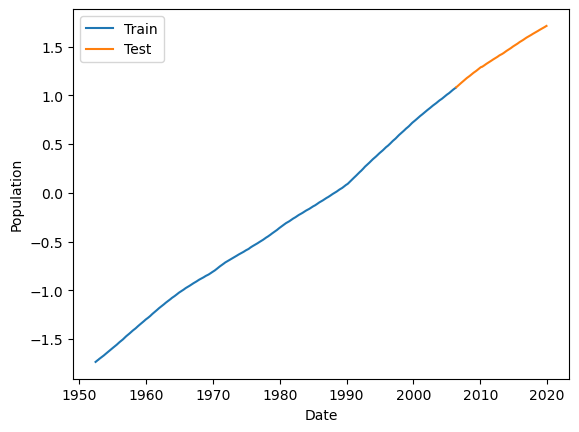

In [11]:
sns.lineplot(x=df['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df['date'].iloc[len(y_train) + window:], y=y_test[:,0], label='Test')
plt.ylabel('Population')
plt.xlabel('Date')

Regression
Neural Network LSTM

In [12]:
# Reshaping the feature values to use them on the LSTM layer from keras
x_train, x_test = x_train.reshape(-1,window,1), x_test.reshape(-1,window,1)

model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='RMSProp')
model.summary()

C:\Users\Megmi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3091 - val_loss: 0.0613
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2799e-04 - val_loss: 0.0208
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0293
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0376
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7679e-04 - val_loss: 0.0027
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0102
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3184e-04 - val_loss: 0.0110
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5053e-04 - val_loss: 0.0076
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9422e-04 - val_loss: 0.0098
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4483e-04 - val_loss: 0.0226


Finally, we have our model ready to predict some values

Text(0, 0.5, 'Cost')

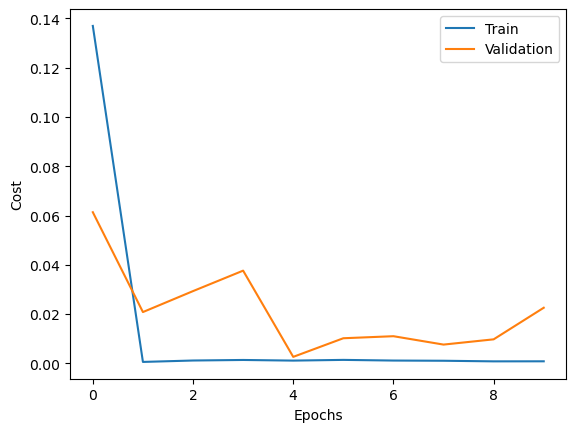

In [14]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

The chart of validation and training dosen't look too good, but that's because the value is already very low, so there's no much where to go, that's why we didn't put many epochs for this, so we don't overfit our model

In [15]:
# Function to print the charts comparing the original dataset with the predicted values
def results_chart(y_predicted, y_test, y_train, x_date, window):
    grid = plt.figure(figsize=(17,20))

    g1 = grid.add_subplot(2,1,1)
    g2 = grid.add_subplot(2,1,2)
    
    sns.lineplot(x=x_date[window:len(y_train) + window], y=y_train[:,0], label='Train', ax=g1)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_test[:,0], label='Test', ax=g1)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_predicted[:,0], label='Predicted', ax=g1)
    g1.set_title('Train x Test x Predict')

    sns.lineplot(x=x_date[len(y_train) + window:], y=y_test[:,0], label='Test', ax=g2)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_predicted[:,0], label='Predicted', ax=g2)
    g2.set_title('Test x Predict')

results_chart is a simple function just to compare the original values with the predicted ones

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

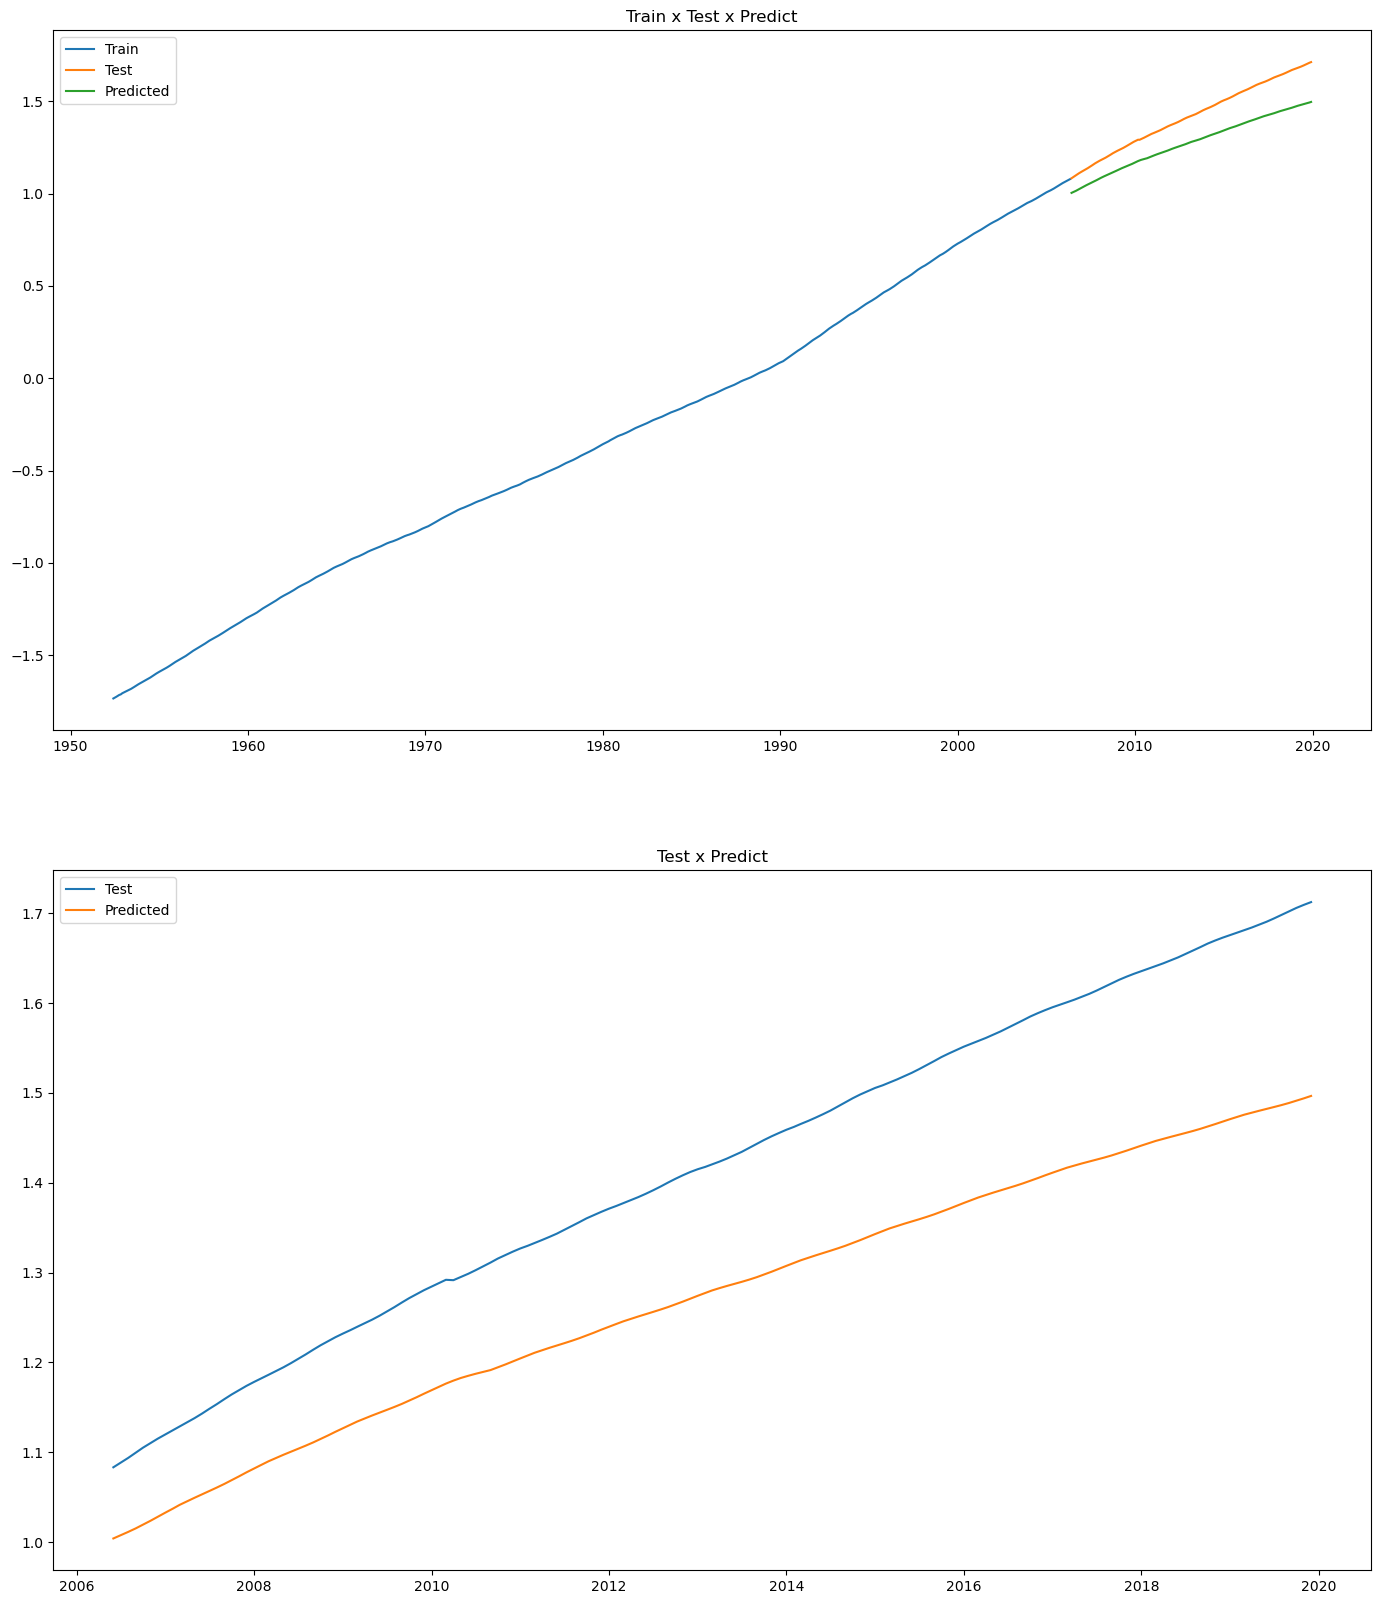

In [16]:
y_predicted = model.predict(x_test)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

The result looks good! Is not perfect, but it's a very good result for a simple neural network without much changes or adjusts

Linear Regression

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

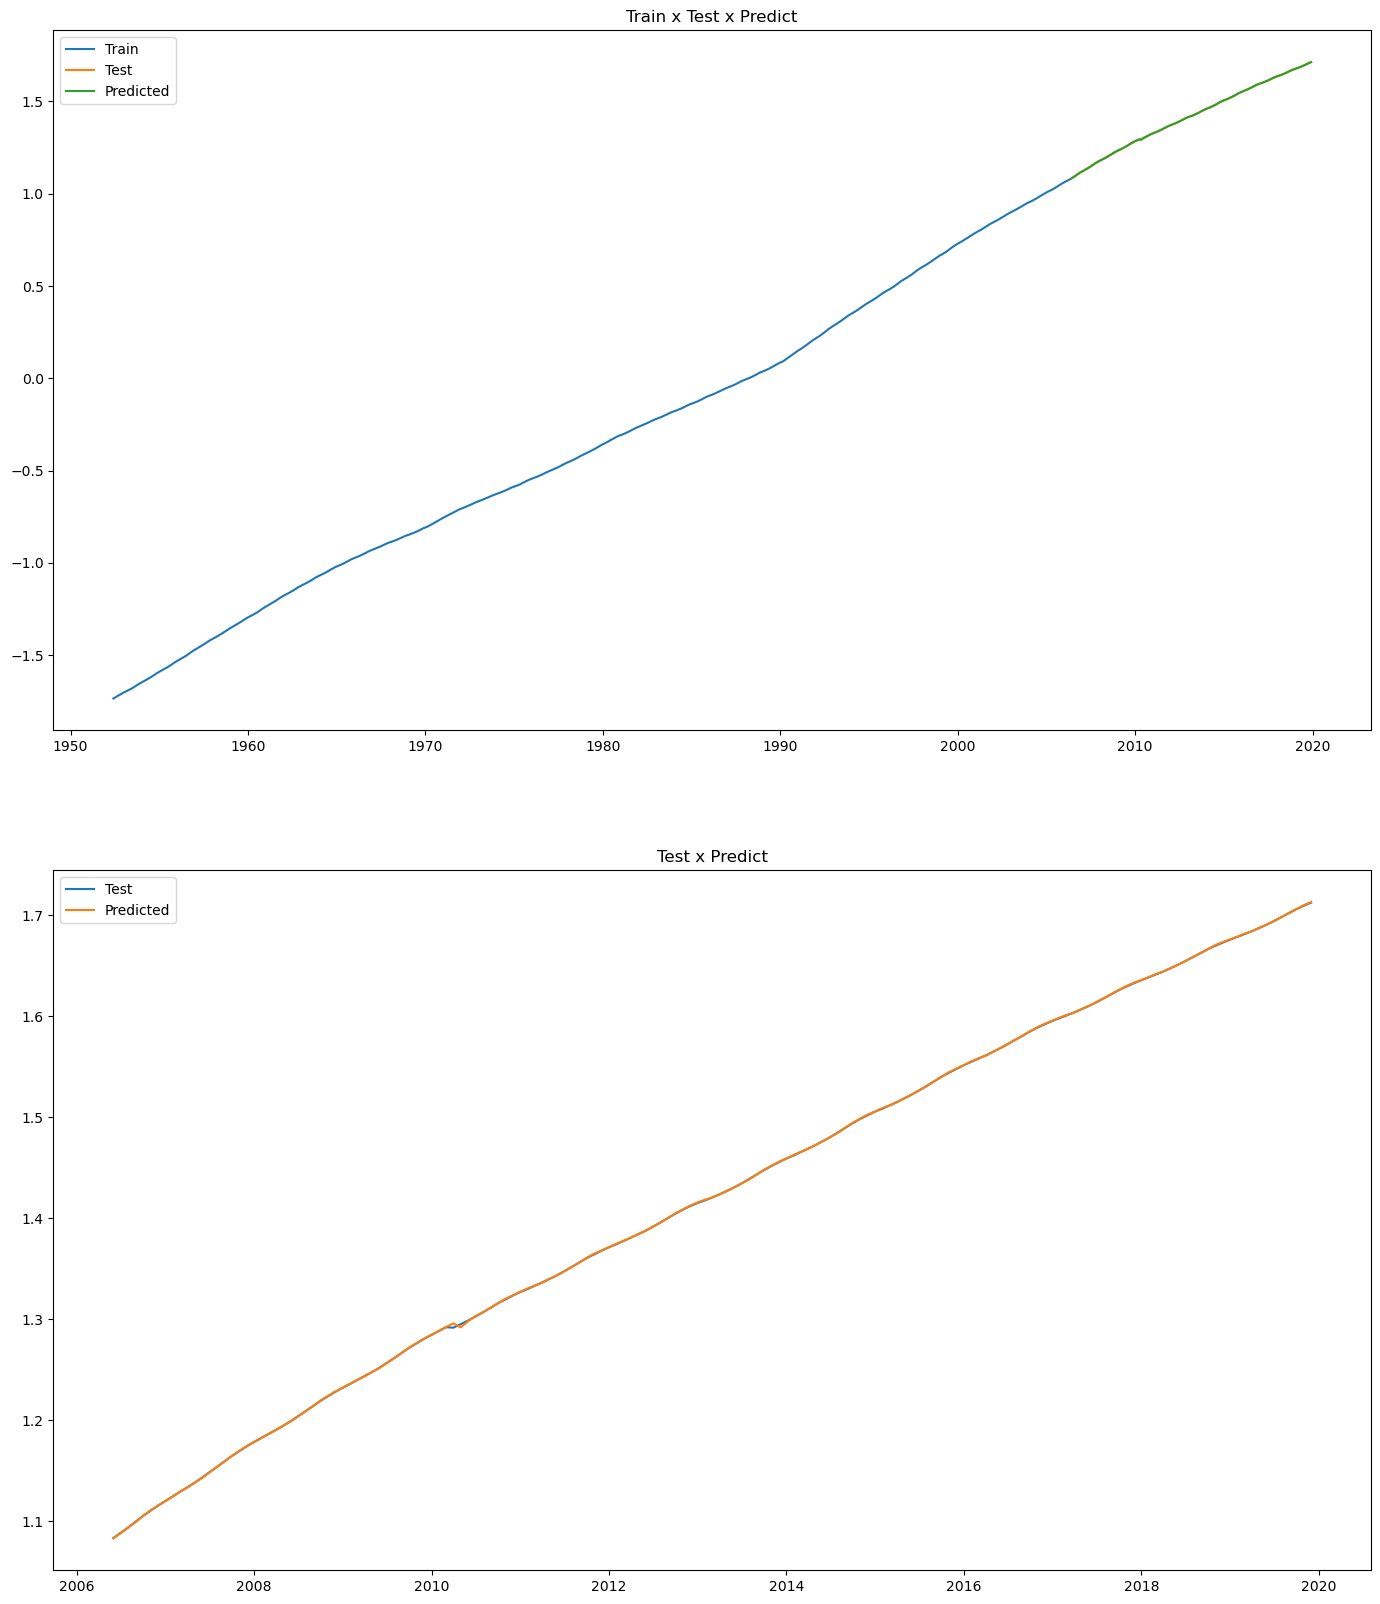

In [17]:
from sklearn.linear_model import LinearRegression

model_linear_reg = LinearRegression().fit(x_train.reshape(-1,window), y_train)
y_predicted = model_linear_reg.predict(x_test.reshape(-1,window))

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

This looks even better than the neural network, but that's probably because the dataset is very simple.

SVR

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

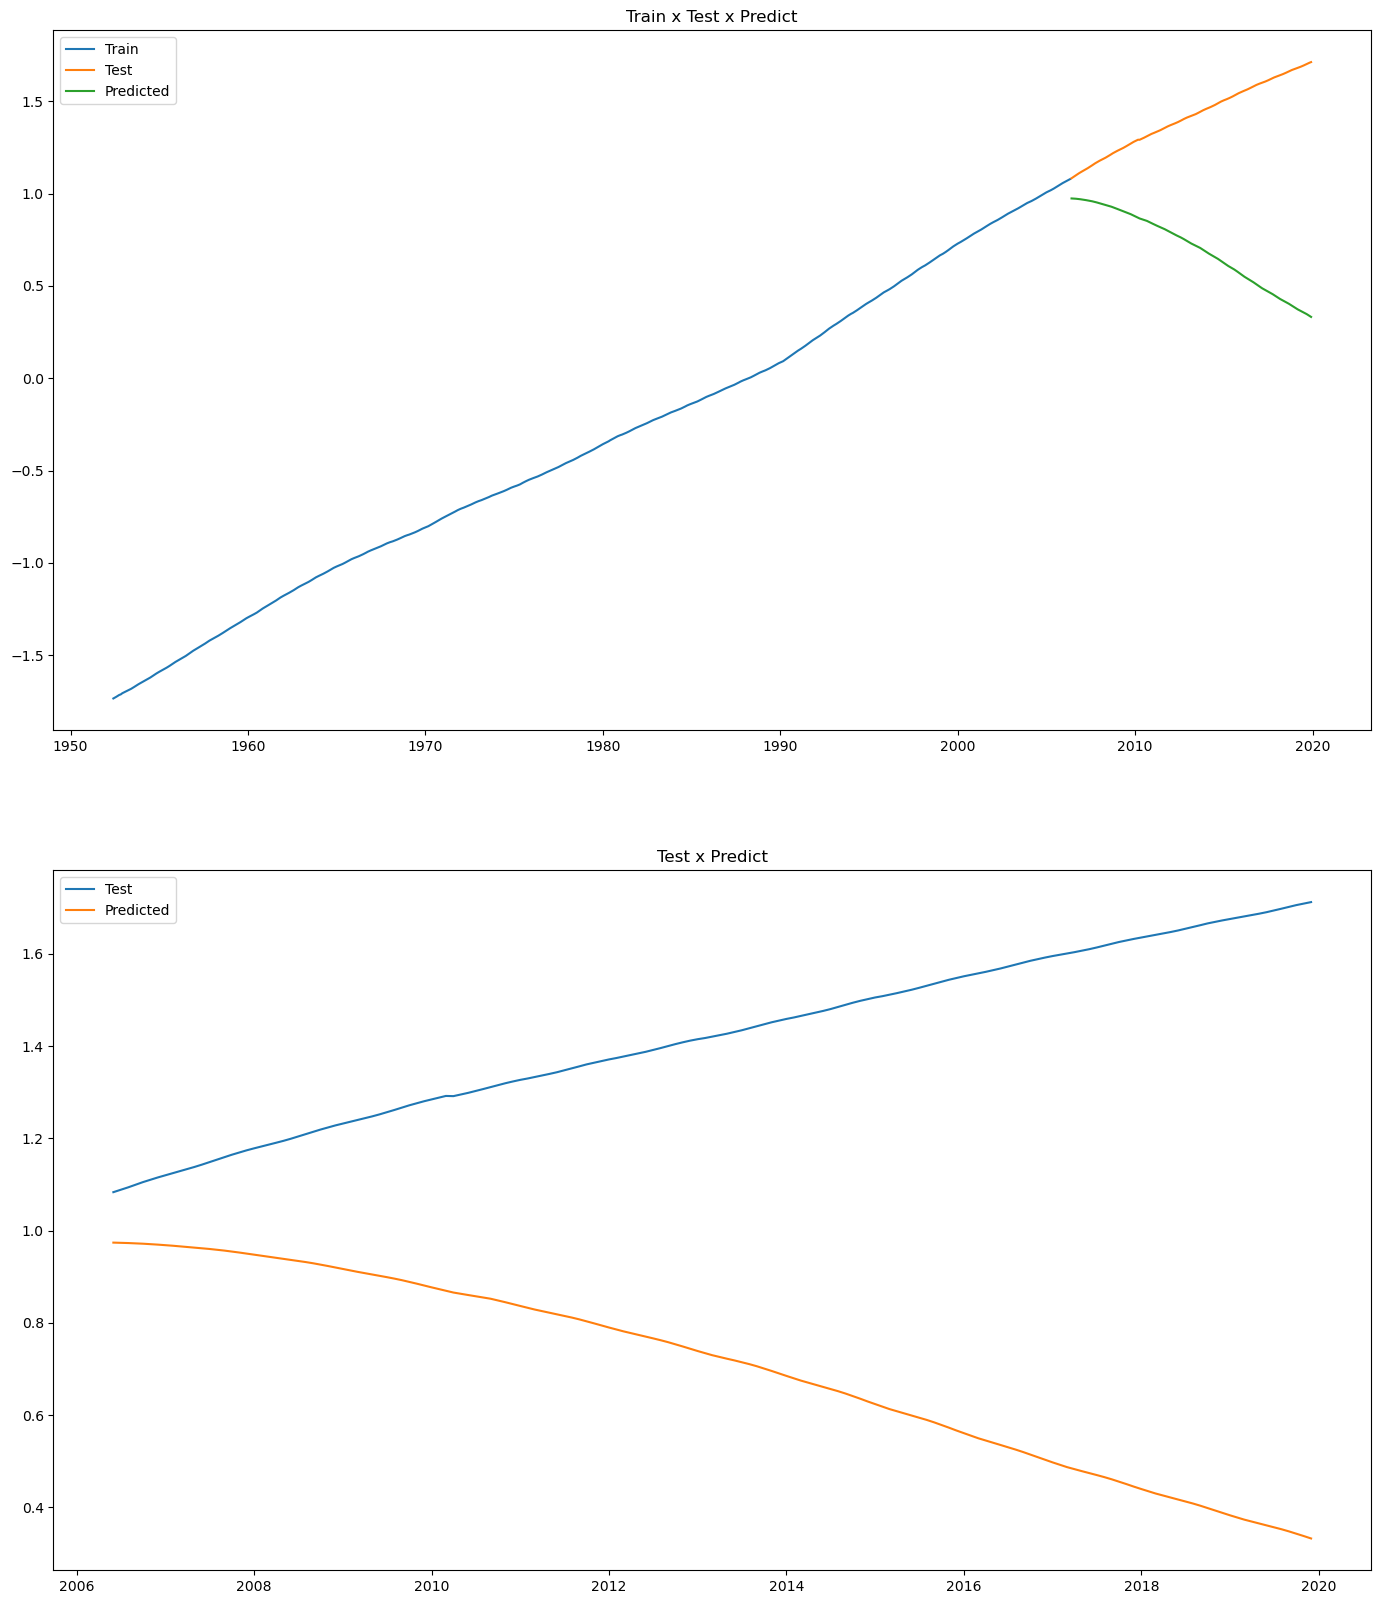

In [18]:
from sklearn.svm import SVR

model_svr = SVR().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_svr.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

Looks like the SVR didn't ajusted very well to the data

SGD Regressor

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

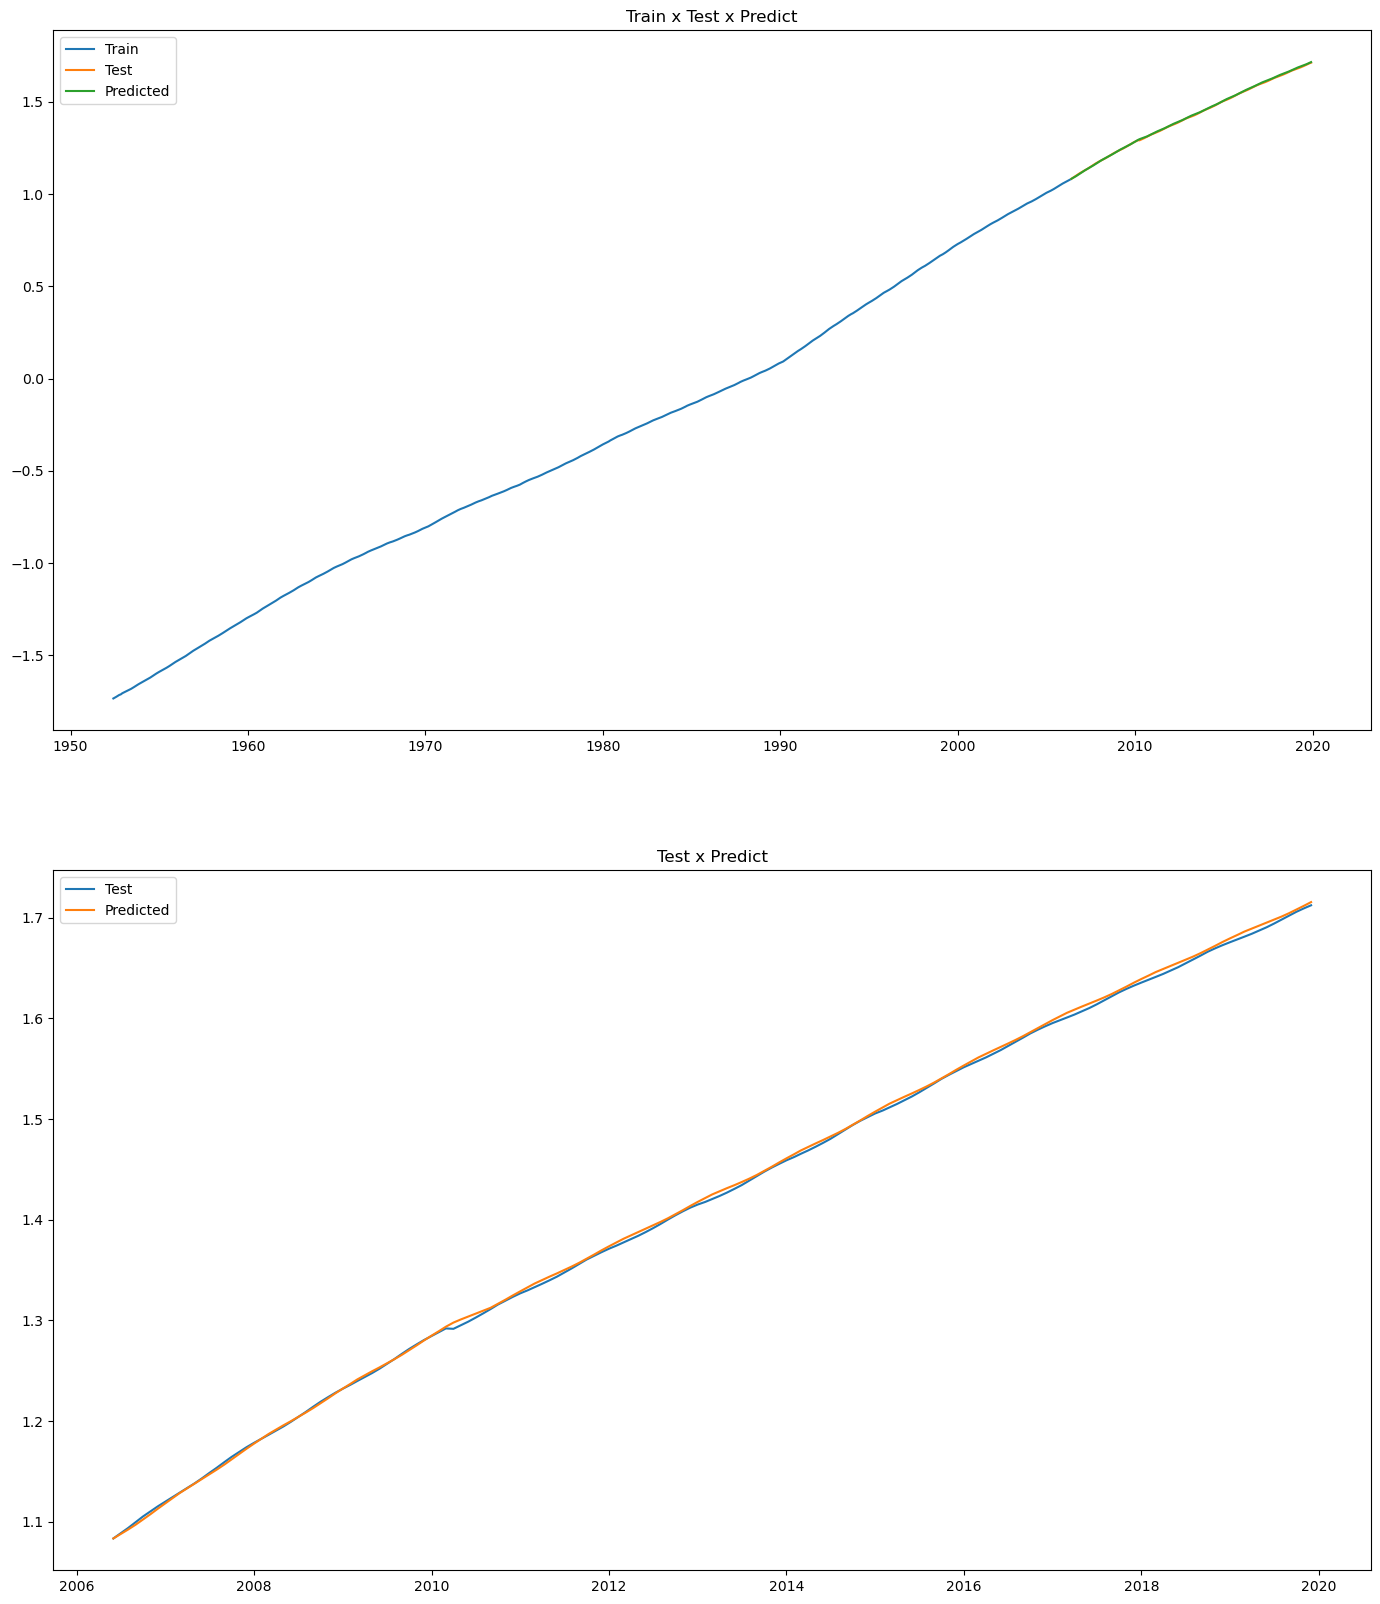

In [19]:
from sklearn.linear_model import SGDRegressor

model_sdgr = SGDRegressor().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_sdgr.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

Very similar to the linear regression!

Decision Tree Regressor

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

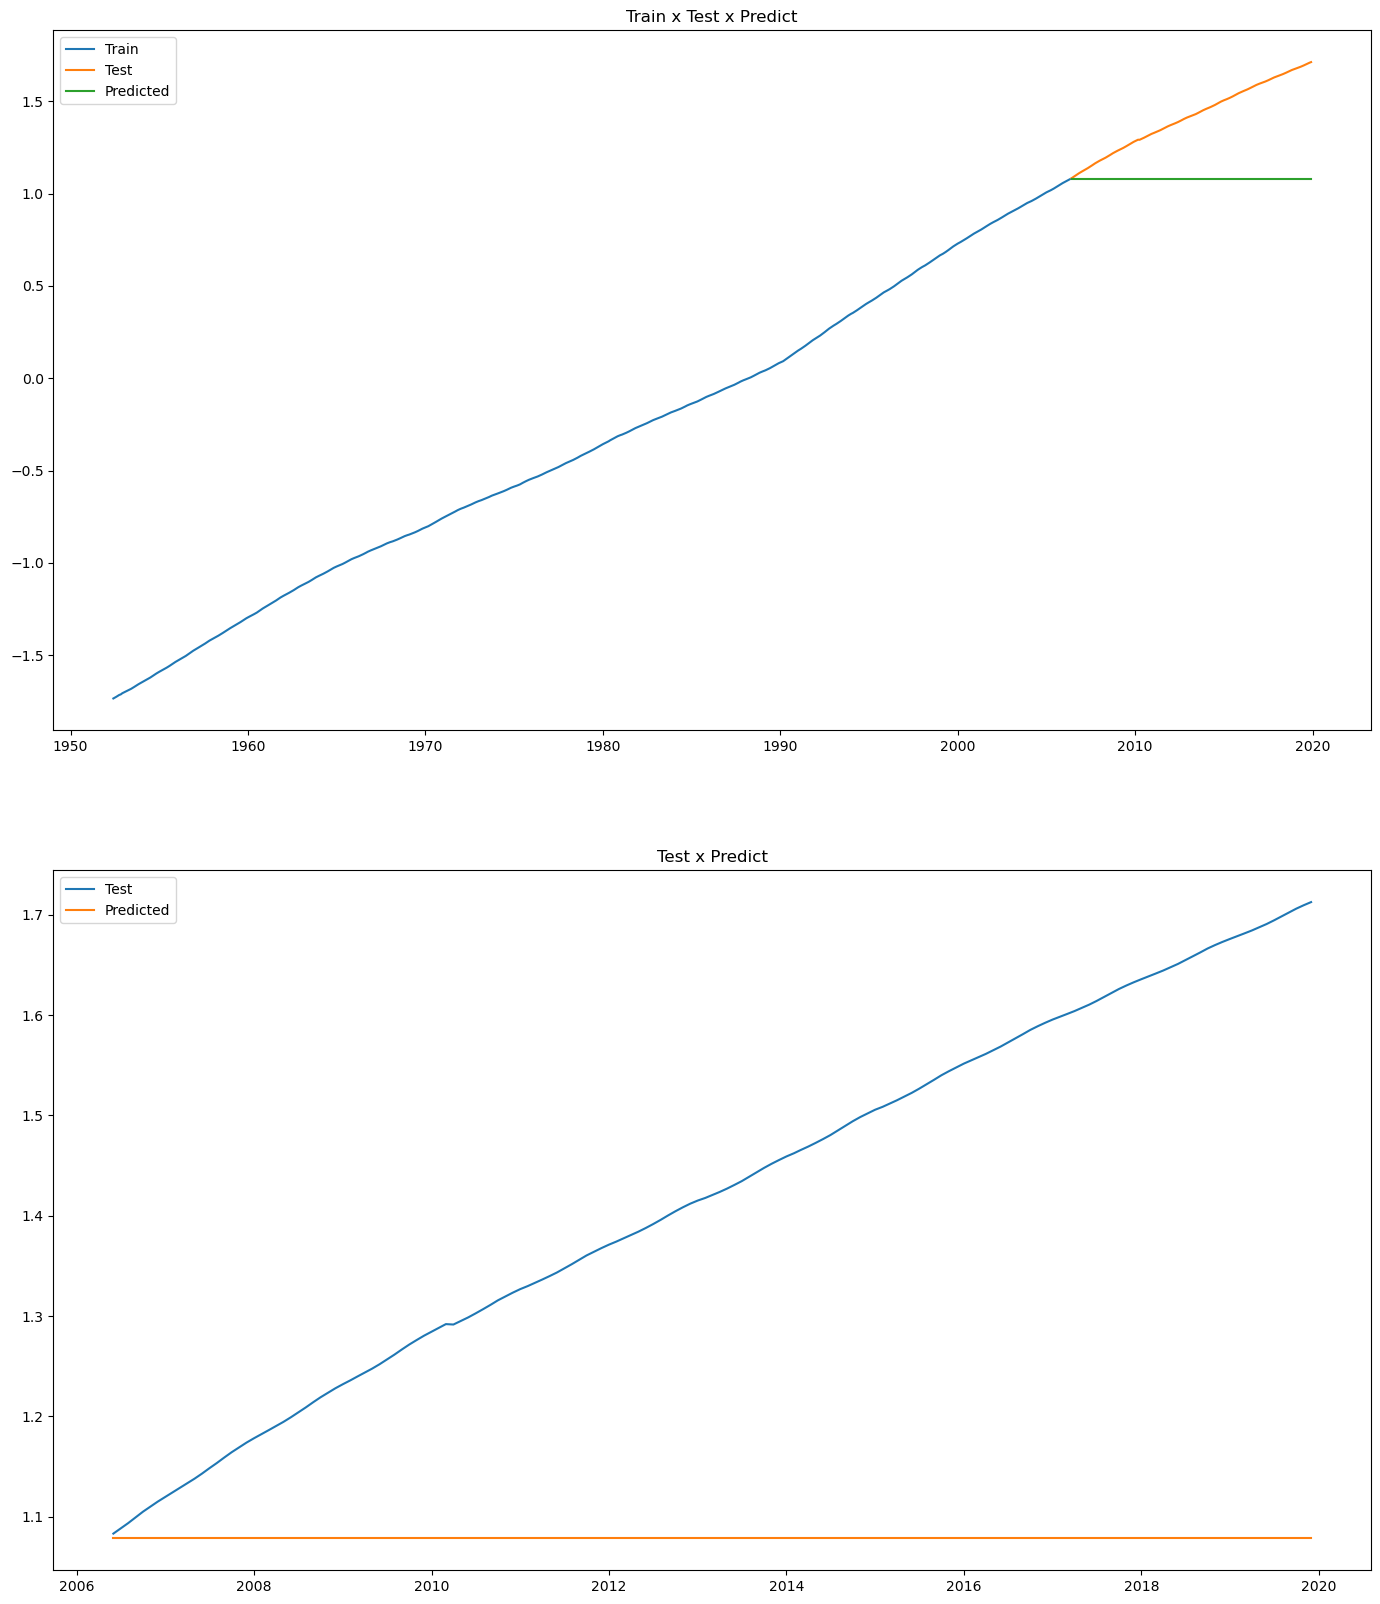

In [20]:
from sklearn.tree import DecisionTreeRegressor

model_decision_tree = DecisionTreeRegressor().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_decision_tree.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

Peculiar result from the Decision Tree Regressor, I think it is necessary to use different paramaters to make it better

Predicting the future

Since the train set was very simple, why not try to predict the distant future?

In this case I created a function to use the previous value calculated to use as entry to the next prediction, so we can create a time series with predicted values!

In [21]:
# Function specific for the lst because of the type of shape
def predict_future_lstm(target, model, window, n=100):
    new_target = target.tolist()
    for i in range(n):
        feature = np.array(new_target[-window:]).reshape(1,window,1)
        target_predicted = model.predict(feature).reshape(1)
        new_target.append(target_predicted)
    return np.array(new_target)

# Generic function for creating our time series with the predicted values
def predict_future(target, model, window, n=100):
    new_target = target.tolist()
    for i in range(n):
        feature = np.array(new_target[-window:]).reshape(-1,window)
        target_predicted = model.predict(feature).reshape(1)
        new_target.append(target_predicted)
    return np.array(new_target)

In [22]:
# n is the number of units of time that i'm predicting
n = 100
target_model_scaled = predict_future_lstm(target_scaled, model, window, n=n)
target_model_linear_scaled = predict_future(target_scaled,model_linear_reg,window,n=n)
target_model_decision_tree_scaled = predict_future(target_scaled,model_decision_tree,window,n=n)
target_model_svr_scaled = predict_future(target_scaled,model_svr,window,n=n)
target_model_sdgr_scaled = predict_future(target_scaled,model_sdgr,window,n=n)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━

In [23]:
# Create the extra date to visualize in the chart 
extra_dates = pd.date_range(df['date'].iloc[-1], periods=n + 1, freq='MS')
extra_dates = extra_dates.to_series().reset_index(drop=True).iloc[1:]
all_dates = pd.concat((df['date'], extra_dates), ignore_index=True)

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

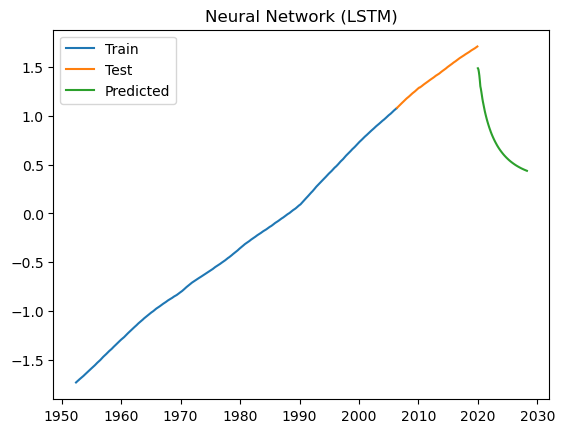

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

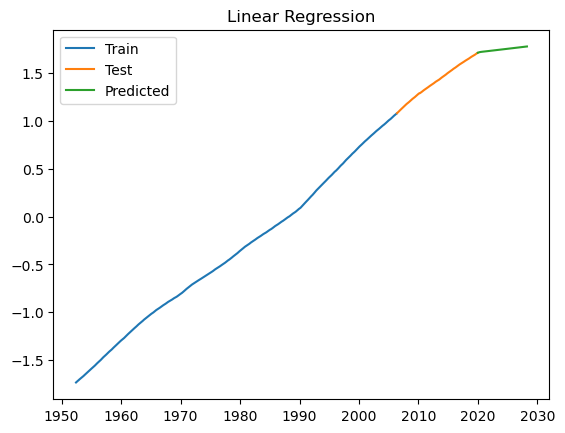

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

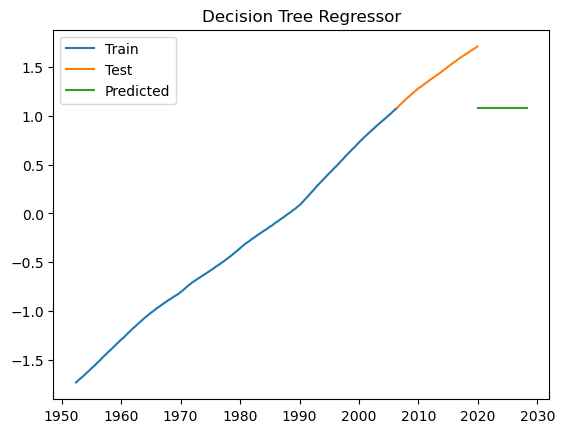

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

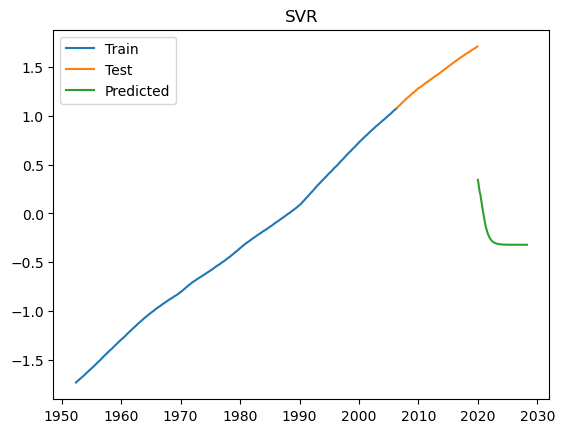

C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Megmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

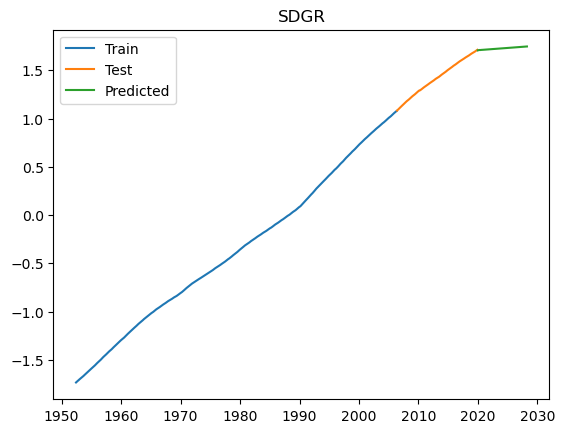

In [24]:
# Function to show the train, test and prediction values
def future_chart(future_target, y_train, y_test, x_date, window, title=''):
    original_target_size = len(y_train) + len(y_test)
    sns.lineplot(x=x_date[window:len(y_train) + window], y=y_train[:,0], label='Train')
    sns.lineplot(x=x_date[len(y_train) + window: original_target_size + window], y=y_test[:,0], label='Test')
    sns.lineplot(x=x_date[original_target_size + window:], y=future_target[original_target_size:,0], label='Predicted')
    plt.title(label=title)
    plt.show()

future_chart(target_model_scaled,  y_train, y_test, all_dates, window, title='Neural Network (LSTM)')
future_chart(target_model_linear_scaled,  y_train, y_test, all_dates, window, title='Linear Regression')
future_chart(target_model_decision_tree_scaled,  y_train, y_test, all_dates, window, title='Decision Tree Regressor')
future_chart(target_model_svr_scaled,  y_train, y_test, all_dates, window, title='SVR')
future_chart(target_model_sdgr_scaled,  y_train, y_test, all_dates, window, title='SDGR')

Well, apparently the linear regression and sdgr had the best results! The other ones didn't have good predictions, but this is expected when you're using predicted values to predict more values.

In the end, even the neural network didn't had good results, probably because it overfited, so some changes need to be done to improve the results in this experiment